In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import env

from sklearn.model_selection import train_test_split

import sklearn.preprocessing

### Acquire

In [2]:
# connection function for accessing mysql 
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def split_data(df, stratify_by=""):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [4]:
query = """
select * 
from properties_2017
join predictions_2017 using(parcelid)
where transactiondate between "2017-05-01" and "2017-06-30"
and unitcnt = 1;
"""

df = pd.read_sql(query, get_connection('zillow'))
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,11289917,2061546,1.0,None,None,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
1,11705026,1834372,NaN,None,None,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30
2,11389003,2121349,NaN,None,None,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,None,NaN,6.037703e+13,3273,-0.325393,2017-06-01
3,11967869,2093710,NaN,None,None,1.0,2.0,NaN,5.0,1.0,...,274237.0,2016.0,191821.0,3267.47,None,NaN,6.037185e+13,3429,-0.005566,2017-06-29
4,12035176,1288537,NaN,None,None,1.0,1.0,NaN,11.0,1.0,...,245906.0,2016.0,146810.0,2926.19,None,NaN,6.037189e+13,5444,-0.114435,2017-05-24


### Prep

In [5]:
# Some prep
df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "square_feet", "taxamount": "taxes", "taxvaluedollarcnt": "tax_value"})

In [6]:
features = [
    "parcelid",
    "bedrooms",
    "bathrooms",
    "square_feet",
    "tax_value"
]

df = df[features]
df = df.set_index("parcelid")

# Let's drop the nulls
df = df.dropna()

In [7]:
train, validate, test = split_data(df, stratify_by="tax_value")

In [8]:
train.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11063835,3.0,2.0,2512.0,119038.0
12464049,2.0,2.0,1253.0,336961.0
11056435,3.0,2.0,1477.0,310574.0
11644296,3.0,3.0,3006.0,813831.0
12543949,2.0,1.0,986.0,243459.0


<AxesSubplot:>

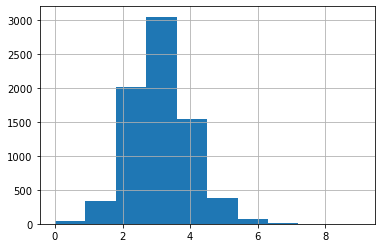

In [9]:
# Step 1 is to get to know individual variables
# Start the distributions
train.bedrooms.hist()

<AxesSubplot:>

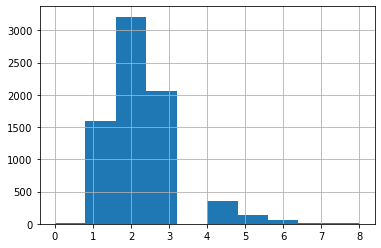

In [10]:
train.bathrooms.hist()

<AxesSubplot:>

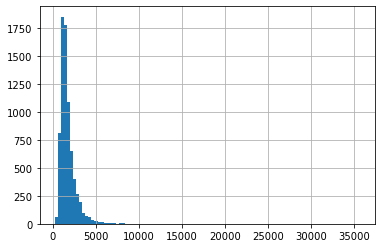

In [11]:
train.square_feet.hist(bins=100)

<AxesSubplot:>

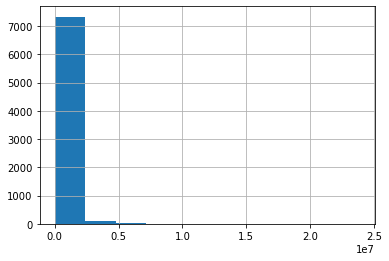

In [12]:
train.tax_value.hist()

### Takeaways so far
- Tax value and square feet have some very extreme outliers
- We may need to ask ourselves at this point if we should remove those outliers or not?
- If the biz question is "what are the drivers of tax_value for properies under 10 million"
- Then we'll definitely drop any values where the tax_value > 10,000,000
- We might use our IQR rule (see the scaling lesson for that)
- We don't automatically toss outliers. We try to get to the heart of the matter of what caused those outliers?

In [13]:
#Let's consider multicolinearity 
train.corr()

,bedrooms,bathrooms,square_feet,tax_value
bedrooms,1.000000,0.582006,0.589331,0.261784
bathrooms,0.582006,1.000000,0.723200,0.469682
square_feet,0.589331,0.723200,1.000000,0.543268
tax_value,0.261784,0.469682,0.543268,1.000000


<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

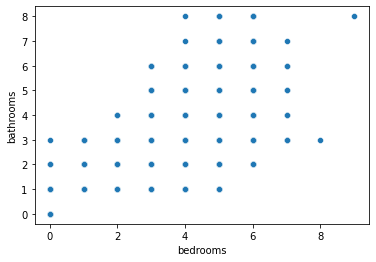

In [14]:
sns.scatterplot(x="bedrooms", y="bathrooms", data=train)

In [15]:
# It looks like bedrooms and bathrooms have some correlation, but it's not super high...
# If we see bedroom to bathroom correlation in the mid/high 90s, we should only choose one or...
# Handle this separately/creatively

# 
train["bed_and_bath_count"] = train.bedrooms + train.bathrooms

In [16]:
train.corr()

,bedrooms,bathrooms,square_feet,tax_value,bed_and_bath_count
bedrooms,1.000000,0.582006,0.589331,0.261784,0.891239
bathrooms,0.582006,1.000000,0.723200,0.469682,0.887513
square_feet,0.589331,0.723200,1.000000,0.543268,0.737285
tax_value,0.261784,0.469682,0.543268,1.000000,0.410291
bed_and_bath_count,0.891239,0.887513,0.737285,0.410291,1.000000


In [17]:
# if we want to use bed_and_bath_count, we avoid bedrooms and bathrooms as future features
# since they're so correlated
# What are some other ways to slice and dice the features?

In [18]:
# What about square_feet_per_room
train["square_ft_per_room"] = train.square_feet / train.bed_and_bath_count

In [19]:
train.corr()

,bedrooms,bathrooms,square_feet,tax_value,bed_and_bath_count,square_ft_per_room
bedrooms,1.000000,0.582006,0.589331,0.261784,0.891239,-0.004548
bathrooms,0.582006,1.000000,0.723200,0.469682,0.887513,0.210080
square_feet,0.589331,0.723200,1.000000,0.543268,0.737285,0.590567
tax_value,0.261784,0.469682,0.543268,1.000000,0.410291,0.355736
bed_and_bath_count,0.891239,0.887513,0.737285,0.410291,1.000000,0.114860
square_ft_per_room,-0.004548,0.210080,0.590567,0.355736,0.114860,1.000000


<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

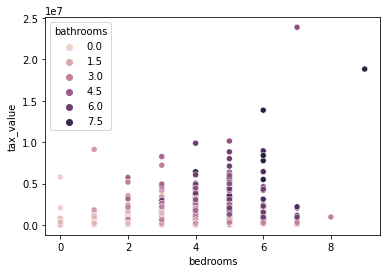

In [20]:
sns.scatterplot(x="bedrooms", y="tax_value", data=train, hue="bathrooms")

<AxesSubplot:xlabel='bathrooms', ylabel='tax_value'>

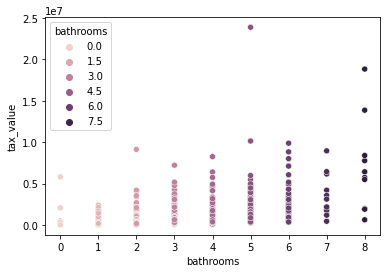

In [21]:
sns.scatterplot(x="bathrooms", y="tax_value", data=train, hue="bathrooms")